## 0. Info & Summary
작성일 : 211203 / 작성자 : 김선진

## 1. 아이템 정의
PHM-Data-Challenge 데이터에 대해 분석결과를 참고해보자 

## 2. 목적
CMP cause analysis

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [113]:
PATH= "C:\\Users\\OnePredict\\Desktop\\CMP\\2016 PHM DATA CHALLENGE CMP DATA SET\\"
stage = "training"
stage_x = 'CMP-data\\'+stage

## 3. CMP data 를 x, y dataframe 로 변환 후 저장
### x data
- TimeSTAMP, Machine_ID, Machine_DATE 제거.
- 다른 논문에는 TimeStamp 에 따른 데이터도 추출하였으므로 우리가 업데이트 해볼만함. 

### y data 
- 1000 이상의 값을 가지는 Outlier 를 제거.

In [137]:
def load_dataframe(PATH, stage, stage_x):
    # get x and y from corresponding dirs
    path = os.path.join(PATH, stage_x)                                     #경로 이름이 연결되고 파일 경로가 획득됩니다. PATH\stage_x
    dataframe_x = pd.DataFrame()
    for file_name in os.listdir(path):
        dataframe = pd.read_csv(os.path.join(path, file_name))
        dataframe = dataframe.drop(columns=['TIMESTAMP','MACHINE_ID','MACHINE_DATA'])                  #'TIMESTAMP'데이터는 의미 없는 평균 데이터, 삭제
        dataframe_x = dataframe_x.append(dataframe,ignore_index=True)
    # dataframe_group_x = dataframe_x.groupby(['WAFER_ID','STAGE'])
    y_path = os.path.join(PATH, "CMP-"+stage+"-removalrate.csv")           #CMP-test-removalrate.csv
    dataframe_y = pd.read_csv(y_path)

    dataframe_y = dataframe_y.loc[dataframe_y['AVG_REMOVAL_RATE'] <= 1000] #1000보다 큰 데이터는 이상값으로 간주되어 폐기될 수 있습니다.
    dataframe_y.hist('AVG_REMOVAL_RATE')                                   #이 열에 대한 분포 히스토그램을 그립니다.
    # plt.hist(dataframe_y['AVG_REMOVAL_RATE'])                            #이 데이터 열을 플로팅합니다. 이 데이터 열은 두 섹션으로 명확하게 나뉩니다.
    # plt.show()

    print("dataframe_x.shape",dataframe_x.shape)
    print("dataframe_y.shape", dataframe_y.shape)
    return dataframe_x, dataframe_y
    # return

### dataframe x,y 에 각 값을 저장. 
#### 아래의 hist 결과는 MRR 데이터에 따른 수 (X : ARR, y:해당 값을 가지는 wafer 수)

dataframe_x.shape (672744, 22)
dataframe_y.shape (1977, 3)


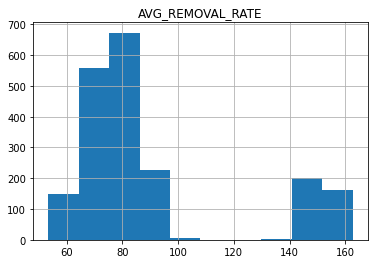

In [138]:
dataframe_x, dataframe_y = load_dataframe(PATH, stage, stage_x)

## 4. x, y dataframe을 statustics로 각 값에 대해 분류
#### - 이때, Wafer ID와 Stage 로 group 해주고, statistics = ['mean','std','min','median','max'] 값으로 분류해줌

In [139]:
def abstract_statistics(dataframe_x, dataframe_y, statistics=['mean','std','min','median','max']):
    # abstract statistics for virtual metrology
    # dataframe_x has dropped timestamps
    dataframe_group_x = dataframe_x.groupby(['WAFER_ID','STAGE'])                       # 그룹 데이터

    dataframe_statistics = dataframe_group_x.agg(statistics)                            # 그룹핑 후 각 차원 데이터의 관련 통계 계산
    # print("dataframe_statistics",dataframe_statistics)
    # dataframe_statistics.to_csv("dataframe_statistics.csv", index=False, sep=',')     # 위의 관련 통계를 csv 파일에 씁니다.

    columns = dataframe_x.columns                                                       # 원본 데이터의 열 이름
    dataframe_statistics.columns = generate_columns_name(columns, statistics)           # 위의 관련 통계 데이터에 대한 새 열 이름 생성
    dataframe_statistics = pd.DataFrame(dataframe_statistics)
    dataframe_statistics.reset_index(inplace=True)                                      # 인덱스 복원 및 누락된 데이터 채우기
    # dataframe_statistics.to_csv("dataframe_statistics_final.csv", index=False, sep=',') # 위의 관련 통계를 csv 파일에 씁니다.

    # data = pd.concat([dataframe_statistics, dataframe_y], ignore_index=True)
    data = pd.merge(dataframe_statistics, dataframe_y)
    # data.to_csv("data_final.csv", index=False, sep=',')
    return data

## 5. Statistics 로 분할한 값들을 feature로 바꿔주고, 필요없는 wafer ID와 Stage를 삭제
- 20개의 데이터를 5개의 통계지표로 변환 -> 총 100개의 feature 생성 
- 제거된 5개의 데이터 : wafer_ID, stage, timestamp, MACHINE_ID, MACHINE_DATA

In [140]:
#함수 기능: 관련 통계 데이터에 대한 새 열 이름 생성
#입력 매개변수: 열: 특성 데이터, 통계: 특성 데이터에 대해 계산할 통계
def generate_columns_name(columns, statistics):
    columns_list = []
    for column in columns:
        for statistic in statistics:
            if column not in ['MACHINE_ID','MACHINE_DATA','TIMESTAMP','WAFER_ID','STAGE']:  #dataframe_statistics 테이블에 없는 열 이름 필터링
                columns_list.append(statistic + "_" + column)
    return columns_list

def load_data(PATH, stage, stage_x):
    dataframe_x, dataframe_y = load_dataframe(PATH, stage, stage_x)
    train_data = abstract_statistics(dataframe_x, dataframe_y)
    train_data = train_data[train_data.columns[2:]].values         # WAFER_ID 및 STAGE 데이터 삭제
    return train_data

In [141]:
#함수 기능：모드 분할
def split_data(data, partitions=[50,100,165]):
    n = len(partitions)
    start = partitions[0]
    splited_data = []
    idx = np.where(data[:,-1]<=start)
    splited_data.append(np.squeeze(data[idx,:],axis=0))
    for i in range(1,n):
        end = partitions[i]
        idx = np.where(data[:,-1]<=start)
        splited_data.append(np.squeeze(data[idx,:], axis=0))
        start = end
    idx = np.where(data[:,-1]>start)
    splited_data.append(np.squeeze(data[idx,:],axis=0))
    # print(splited_data)
    return splited_data

def split_data_label(data):
    x = data[:,:-1]
    y = data[:,-1]
    return x, y

## 6. 각 데이터를 모델 분석에 용이하게 하기 위해 np 데이터로 npy 파일로 저장 
- 아래는 training 만 생성 
- test 의 경우 MRR 값이 ? 로 되어있기 때문에 위 코드가 돌아가지 않음
- Validation 데이터가 존재하지않음 

dataframe_x.shape (672744, 22)
dataframe_y.shape (1977, 3)
dataframe_x.shape (156262, 22)
dataframe_y.shape (424, 3)


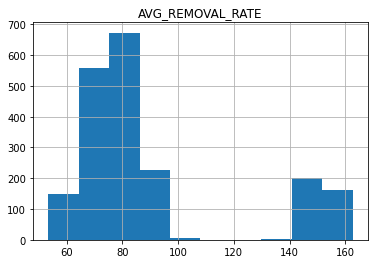

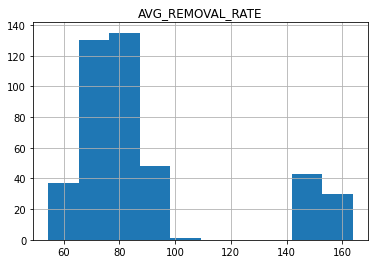

In [143]:
if __name__ == "__main__":
    # 훈련 데이터 세트, 테스트 데이터 세트 및 검증 데이터 세트를 별도로 생성
    # train_data
    PATH = "C:\\Users\\OnePredict\\Desktop\\CMP\\2016 PHM DATA CHALLENGE CMP DATA SET\\"
    stage = "training"
    stage_x = 'CMP-data\\'+stage
    train_data = load_data(PATH, stage, stage_x)
    np.save("C:\\Users\\OnePredict\\Desktop\\CMP\\2016 PHM DATA CHALLENGE CMP DATA SET\\CMP-data\\Processed data set\\train_data.npy", train_data)

    # test_data
    PATH = "C:\\Users\\OnePredict\\Desktop\\CMP\\2016 PHM DATA CHALLENGE CMP DATA SET\\"
    stage = "test"
    stage_x = 'CMP-data\\'+stage
    test_data =load_data(PATH, stage, stage_x)
    np.save("C:\\Users\\OnePredict\\Desktop\\CMP\\2016 PHM DATA CHALLENGE CMP DATA SET\\CMP-data\\Processed data set\\test_data.npy", test_data)

    # validation_data
    # PATH = "C:\\Users\\OnePredict\\Desktop\\CMP\\2016 PHM DATA CHALLENGE CMP DATA SET\\"
    # stage = "validation"
    # stage_x = stage
    # validation_data = load_data(PATH, stage, stage_x)
    # np.save("./Processed data set/validation_data.npy", validation_data)


## 7. 저장된 npy 데이터를 간단하게 확인해보자 
- 순서대로, npy 데이터와 y_column 명을 제거하기 전 npy 데이터 이므로 참고하기

In [134]:
pd.DataFrame(train_data).head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,4.670520,0.802964,4.0,4.0,6.0,890.069846,3.709068,884.166667,890.833333,896.666667,...,0.494122,0.0,1.0,1.0,38.540025,20.556539,0.0,48.484848,57.878788,68.88180
1,4.890625,0.809109,4.0,5.0,6.0,1291.998698,4.324576,1285.833333,1293.333333,1298.333333,...,0.500735,0.0,0.0,1.0,47.890625,28.886909,0.0,44.242424,106.363636,70.05330
2,4.646240,0.798169,4.0,4.0,6.0,3272.829619,3.423431,3266.666667,3273.333333,3277.500000,...,0.394580,0.0,1.0,1.0,40.990968,43.215477,0.0,43.939394,141.515152,54.30720
3,4.660819,0.800760,4.0,4.0,6.0,5922.780214,2.480098,5918.333333,5924.166667,5925.000000,...,0.481447,0.0,1.0,1.0,20.260500,24.245019,0.0,0.000000,57.878788,75.34995
4,4.659884,0.799428,4.0,4.0,6.0,4868.350291,2.159261,4864.166667,4870.000000,4870.000000,...,0.498557,0.0,1.0,1.0,19.943622,24.456932,0.0,0.000000,57.878788,78.33015


In [135]:
abstract_statistics(dataframe_x, dataframe_y, statistics=['mean','std','min','median','max']).head()

,WAFER_ID,STAGE,mean_CHAMBER,std_CHAMBER,min_CHAMBER,median_CHAMBER,max_CHAMBER,mean_USAGE_OF_BACKING_FILM,std_USAGE_OF_BACKING_FILM,min_USAGE_OF_BACKING_FILM,...,std_DRESSING_WATER_STATUS,min_DRESSING_WATER_STATUS,median_DRESSING_WATER_STATUS,max_DRESSING_WATER_STATUS,mean_EDGE_AIR_BAG_PRESSURE,std_EDGE_AIR_BAG_PRESSURE,min_EDGE_AIR_BAG_PRESSURE,median_EDGE_AIR_BAG_PRESSURE,max_EDGE_AIR_BAG_PRESSURE,AVG_REMOVAL_RATE
0,-4230160598,A,4.670520,0.802964,4.0,4.0,6.0,890.069846,3.709068,884.166667,...,0.494122,0.0,1.0,1.0,38.540025,20.556539,0.0,48.484848,57.878788,68.88180
1,-4230160594,B,4.890625,0.809109,4.0,5.0,6.0,1291.998698,4.324576,1285.833333,...,0.500735,0.0,0.0,1.0,47.890625,28.886909,0.0,44.242424,106.363636,70.05330
2,-4230160436,B,4.646240,0.798169,4.0,4.0,6.0,3272.829619,3.423431,3266.666667,...,0.394580,0.0,1.0,1.0,40.990968,43.215477,0.0,43.939394,141.515152,54.30720
3,-4230160428,A,4.660819,0.800760,4.0,4.0,6.0,5922.780214,2.480098,5918.333333,...,0.481447,0.0,1.0,1.0,20.260500,24.245019,0.0,0.000000,57.878788,75.34995
4,-4230160424,A,4.659884,0.799428,4.0,4.0,6.0,4868.350291,2.159261,4864.166667,...,0.498557,0.0,1.0,1.0,19.943622,24.456932,0.0,0.000000,57.878788,78.33015
